# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

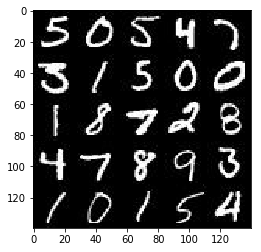

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

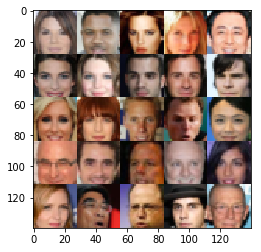

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        print("discriminator-images.shape", images.shape)
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        relu1 = tf.maximum(alpha*x1, x1)
        relu1 = tf.nn.dropout(relu1, 0.8)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding="same")
        bn2 = tf.layers.batch_normalization(x2, training=False)
        relu2 = tf.maximum(alpha*bn2, bn2)
        relu2 = tf.nn.dropout(relu2, 0.8)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding="same")
        bn3 = tf.layers.batch_normalization(x3, training=False)
        relu3 = tf.maximum(alpha*bn3, bn3)
        relu3 = tf.nn.dropout(relu3, 0.8)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        
        return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

discriminator-images.shape (?, 28, 28, 3)
discriminator-images.shape (?, 28, 28, 3)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        print("generator z", z)
        print("generator x1.shape", x1.shape)
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1*alpha, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2*alpha, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3*alpha, x3)
        
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding="same")
        
        out = tf.tanh(logits)
        
        print("out, out_channel_dim", out, out_channel_dim)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

generator z Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("Tanh:0", shape=(?, 28, 28, 5), dtype=float32) 5
generator z Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("Tanh_1:0", shape=(?, 28, 28, 5), dtype=float32) 5
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    print("model_loss-gmodel:", g_model.shape)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*0.9))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

generator z Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator/Tanh:0", shape=(?, 28, 28, 4), dtype=float32) 4
discriminator-images.shape (?, 28, 28, 4)
model_loss-gmodel: (?, 28, 28, 4)
discriminator-images.shape (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100
        
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *=2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_z = batch_z.reshape(batch_size, z_dim)
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images})
                
                
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 20, inputs_z, data_shape[3], data_image_mode)
                    #gen_samples = sess.run(
                    #               generator(inputs_z, data_shape[3], is_train=False),
                    #               feed_dict={inputs_z: sample_z})
                    #samples.append(gen_samples)
                    #_ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    #plt.show()
        #saver.save(sess, './checkpoints/generator.ckpt')
    #with open('samples.pkl', 'wb') as f:
        #pkl.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1
discriminator-images.shape (?, 28, 28, 1)
model_loss-gmodel: (?, 28, 28, 1)
discriminator-images.shape (?, 28, 28, 1)
Epoch 1/3... Step 10... Discriminator Loss: 2.0510... Generator Loss: 0.4287
Epoch 1/3... Step 20... Discriminator Loss: 1.8824... Generator Loss: 0.9236
Epoch 1/3... Step 30... Discriminator Loss: 1.4678... Generator Loss: 0.6993
Epoch 1/3... Step 40... Discriminator Loss: 1.1927... Generator Loss: 2.0549
Epoch 1/3... Step 50... Discriminator Loss: 1.9230... Generator Loss: 0.4963
Epoch 1/3... Step 60... Discriminator Loss: 1.2287... Generator Loss: 1.0917
Epoch 1/3... Step 70... Discriminator Loss: 0.5081... Generator Loss: 3.8322
Epoch 1/3... Step 80... Discriminator Loss: 0.4773... Generator Loss: 4.0239
Epoch 1/3... Step 90... Discriminator Loss: 0.4335... Generator Loss: 2.9036
Epoch 1/3

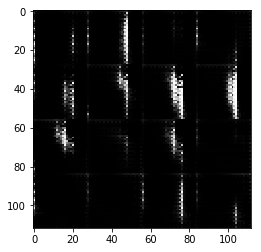

Epoch 1/3... Step 110... Discriminator Loss: 0.5586... Generator Loss: 2.6629
Epoch 1/3... Step 120... Discriminator Loss: 0.7452... Generator Loss: 1.8205
Epoch 1/3... Step 130... Discriminator Loss: 0.6045... Generator Loss: 2.7176
Epoch 1/3... Step 140... Discriminator Loss: 0.6385... Generator Loss: 2.5612
Epoch 1/3... Step 150... Discriminator Loss: 0.8798... Generator Loss: 1.9786
Epoch 1/3... Step 160... Discriminator Loss: 0.7891... Generator Loss: 2.9172
Epoch 1/3... Step 170... Discriminator Loss: 0.6639... Generator Loss: 2.7129
Epoch 1/3... Step 180... Discriminator Loss: 0.9477... Generator Loss: 2.0068
Epoch 1/3... Step 190... Discriminator Loss: 0.5976... Generator Loss: 6.5327
Epoch 1/3... Step 200... Discriminator Loss: 0.5209... Generator Loss: 3.9185
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_2/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


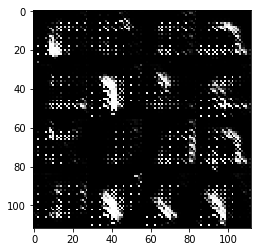

Epoch 1/3... Step 210... Discriminator Loss: 0.7059... Generator Loss: 2.8121
Epoch 1/3... Step 220... Discriminator Loss: 0.7491... Generator Loss: 2.8044
Epoch 1/3... Step 230... Discriminator Loss: 0.7228... Generator Loss: 3.0558
Epoch 1/3... Step 240... Discriminator Loss: 0.6380... Generator Loss: 2.5552
Epoch 1/3... Step 250... Discriminator Loss: 1.4844... Generator Loss: 1.3042
Epoch 1/3... Step 260... Discriminator Loss: 0.6629... Generator Loss: 2.3354
Epoch 1/3... Step 270... Discriminator Loss: 1.2429... Generator Loss: 1.6395
Epoch 1/3... Step 280... Discriminator Loss: 0.8396... Generator Loss: 2.0465
Epoch 1/3... Step 290... Discriminator Loss: 1.1067... Generator Loss: 1.9481
Epoch 1/3... Step 300... Discriminator Loss: 0.8075... Generator Loss: 1.7741
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_3/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


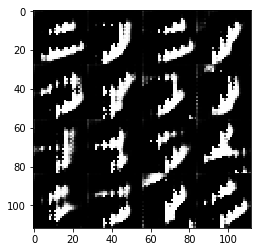

Epoch 1/3... Step 310... Discriminator Loss: 0.6867... Generator Loss: 2.3883
Epoch 1/3... Step 320... Discriminator Loss: 0.6168... Generator Loss: 2.8810
Epoch 1/3... Step 330... Discriminator Loss: 1.3994... Generator Loss: 1.5509
Epoch 1/3... Step 340... Discriminator Loss: 0.7052... Generator Loss: 2.3749
Epoch 1/3... Step 350... Discriminator Loss: 0.7680... Generator Loss: 2.7736
Epoch 1/3... Step 360... Discriminator Loss: 1.3151... Generator Loss: 1.0311
Epoch 1/3... Step 370... Discriminator Loss: 0.9710... Generator Loss: 2.1246
Epoch 1/3... Step 380... Discriminator Loss: 0.9949... Generator Loss: 1.7157
Epoch 1/3... Step 390... Discriminator Loss: 0.7391... Generator Loss: 1.7820
Epoch 1/3... Step 400... Discriminator Loss: 0.7352... Generator Loss: 2.1101
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_4/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


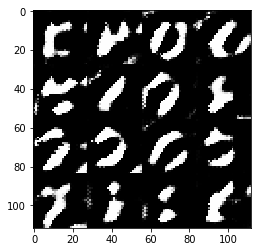

Epoch 1/3... Step 410... Discriminator Loss: 1.1482... Generator Loss: 1.7065
Epoch 1/3... Step 420... Discriminator Loss: 0.7449... Generator Loss: 1.9213
Epoch 1/3... Step 430... Discriminator Loss: 0.9427... Generator Loss: 1.4864
Epoch 1/3... Step 440... Discriminator Loss: 1.0304... Generator Loss: 2.0384
Epoch 1/3... Step 450... Discriminator Loss: 0.9790... Generator Loss: 1.9230
Epoch 1/3... Step 460... Discriminator Loss: 0.6279... Generator Loss: 2.8392
Epoch 1/3... Step 470... Discriminator Loss: 0.8920... Generator Loss: 1.4864
Epoch 1/3... Step 480... Discriminator Loss: 0.9622... Generator Loss: 1.7930
Epoch 1/3... Step 490... Discriminator Loss: 0.8923... Generator Loss: 1.6728
Epoch 1/3... Step 500... Discriminator Loss: 0.7916... Generator Loss: 1.7214
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_5/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


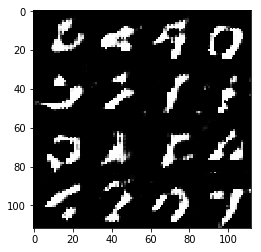

Epoch 1/3... Step 510... Discriminator Loss: 0.8051... Generator Loss: 1.9215
Epoch 1/3... Step 520... Discriminator Loss: 1.2118... Generator Loss: 2.1152
Epoch 1/3... Step 530... Discriminator Loss: 1.4200... Generator Loss: 2.1086
Epoch 1/3... Step 540... Discriminator Loss: 0.7985... Generator Loss: 2.4478
Epoch 1/3... Step 550... Discriminator Loss: 0.9476... Generator Loss: 1.6101
Epoch 1/3... Step 560... Discriminator Loss: 0.8976... Generator Loss: 1.3318
Epoch 1/3... Step 570... Discriminator Loss: 1.0256... Generator Loss: 1.9316
Epoch 1/3... Step 580... Discriminator Loss: 1.0333... Generator Loss: 1.7241
Epoch 1/3... Step 590... Discriminator Loss: 0.8483... Generator Loss: 1.5887
Epoch 1/3... Step 600... Discriminator Loss: 1.0735... Generator Loss: 2.0519
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_6/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


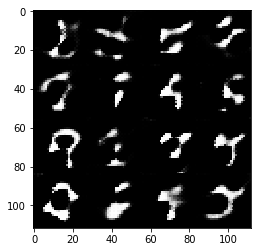

Epoch 2/3... Step 610... Discriminator Loss: 0.9608... Generator Loss: 1.6394
Epoch 2/3... Step 620... Discriminator Loss: 1.1434... Generator Loss: 1.9709
Epoch 2/3... Step 630... Discriminator Loss: 0.9781... Generator Loss: 1.1314
Epoch 2/3... Step 640... Discriminator Loss: 1.0312... Generator Loss: 1.9724
Epoch 2/3... Step 650... Discriminator Loss: 0.7755... Generator Loss: 2.1585
Epoch 2/3... Step 660... Discriminator Loss: 2.4464... Generator Loss: 0.7465
Epoch 2/3... Step 670... Discriminator Loss: 0.7205... Generator Loss: 1.7893
Epoch 2/3... Step 680... Discriminator Loss: 1.8063... Generator Loss: 0.8775
Epoch 2/3... Step 690... Discriminator Loss: 0.9066... Generator Loss: 1.3907
Epoch 2/3... Step 700... Discriminator Loss: 1.0807... Generator Loss: 1.6795
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_7/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


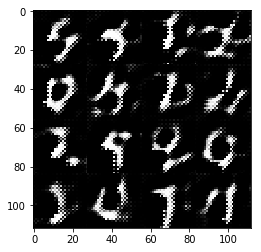

Epoch 2/3... Step 710... Discriminator Loss: 1.5272... Generator Loss: 0.6582
Epoch 2/3... Step 720... Discriminator Loss: 0.6389... Generator Loss: 3.6448
Epoch 2/3... Step 730... Discriminator Loss: 1.0837... Generator Loss: 2.1377
Epoch 2/3... Step 740... Discriminator Loss: 1.1508... Generator Loss: 1.8972
Epoch 2/3... Step 750... Discriminator Loss: 0.9806... Generator Loss: 1.8244
Epoch 2/3... Step 760... Discriminator Loss: 1.2619... Generator Loss: 1.1301
Epoch 2/3... Step 770... Discriminator Loss: 0.5875... Generator Loss: 2.2667
Epoch 2/3... Step 780... Discriminator Loss: 1.1881... Generator Loss: 1.4771
Epoch 2/3... Step 790... Discriminator Loss: 1.1381... Generator Loss: 1.2481
Epoch 2/3... Step 800... Discriminator Loss: 0.9471... Generator Loss: 1.7576
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_8/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


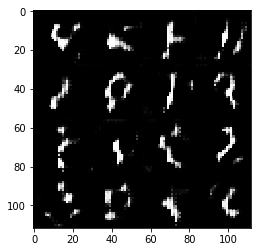

Epoch 2/3... Step 810... Discriminator Loss: 1.0861... Generator Loss: 1.5423
Epoch 2/3... Step 820... Discriminator Loss: 0.9709... Generator Loss: 1.3297
Epoch 2/3... Step 830... Discriminator Loss: 1.0070... Generator Loss: 1.5325
Epoch 2/3... Step 840... Discriminator Loss: 1.5118... Generator Loss: 0.8700
Epoch 2/3... Step 850... Discriminator Loss: 0.9456... Generator Loss: 1.3617
Epoch 2/3... Step 860... Discriminator Loss: 0.7428... Generator Loss: 1.8389
Epoch 2/3... Step 870... Discriminator Loss: 1.1666... Generator Loss: 1.5173
Epoch 2/3... Step 880... Discriminator Loss: 0.7015... Generator Loss: 1.8823
Epoch 2/3... Step 890... Discriminator Loss: 1.0831... Generator Loss: 1.6085
Epoch 2/3... Step 900... Discriminator Loss: 0.9131... Generator Loss: 1.2597
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_9/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


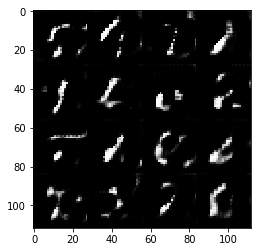

Epoch 2/3... Step 910... Discriminator Loss: 1.0199... Generator Loss: 1.6932
Epoch 2/3... Step 920... Discriminator Loss: 1.3475... Generator Loss: 1.3059
Epoch 2/3... Step 930... Discriminator Loss: 0.8424... Generator Loss: 1.6377
Epoch 2/3... Step 940... Discriminator Loss: 1.7314... Generator Loss: 1.0829
Epoch 2/3... Step 950... Discriminator Loss: 0.9576... Generator Loss: 1.4961
Epoch 2/3... Step 960... Discriminator Loss: 1.3200... Generator Loss: 1.4481
Epoch 2/3... Step 970... Discriminator Loss: 1.0094... Generator Loss: 1.1956
Epoch 2/3... Step 980... Discriminator Loss: 0.8641... Generator Loss: 2.1687
Epoch 2/3... Step 990... Discriminator Loss: 1.1983... Generator Loss: 1.1931
Epoch 2/3... Step 1000... Discriminator Loss: 0.8452... Generator Loss: 1.9427
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_10/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


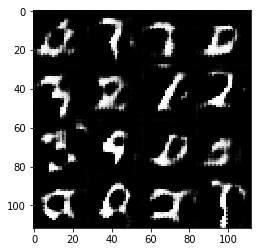

Epoch 2/3... Step 1010... Discriminator Loss: 0.9245... Generator Loss: 1.4476
Epoch 2/3... Step 1020... Discriminator Loss: 1.6152... Generator Loss: 0.7491
Epoch 2/3... Step 1030... Discriminator Loss: 1.3762... Generator Loss: 0.9776
Epoch 2/3... Step 1040... Discriminator Loss: 1.0317... Generator Loss: 1.2370
Epoch 2/3... Step 1050... Discriminator Loss: 1.1617... Generator Loss: 1.3556
Epoch 2/3... Step 1060... Discriminator Loss: 1.5399... Generator Loss: 0.9431
Epoch 2/3... Step 1070... Discriminator Loss: 1.1492... Generator Loss: 0.9619
Epoch 2/3... Step 1080... Discriminator Loss: 0.9606... Generator Loss: 1.2821
Epoch 2/3... Step 1090... Discriminator Loss: 1.1164... Generator Loss: 1.3798
Epoch 2/3... Step 1100... Discriminator Loss: 0.9323... Generator Loss: 1.5415
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_11/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


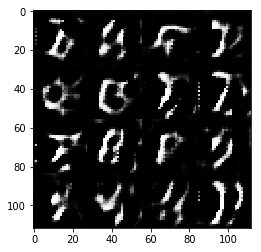

Epoch 2/3... Step 1110... Discriminator Loss: 0.6537... Generator Loss: 1.9727
Epoch 2/3... Step 1120... Discriminator Loss: 1.3956... Generator Loss: 0.9591
Epoch 2/3... Step 1130... Discriminator Loss: 1.3338... Generator Loss: 1.3224
Epoch 2/3... Step 1140... Discriminator Loss: 0.9900... Generator Loss: 1.4055
Epoch 2/3... Step 1150... Discriminator Loss: 1.0826... Generator Loss: 1.1488
Epoch 2/3... Step 1160... Discriminator Loss: 1.4896... Generator Loss: 0.9438
Epoch 2/3... Step 1170... Discriminator Loss: 0.8516... Generator Loss: 1.6484
Epoch 2/3... Step 1180... Discriminator Loss: 1.2472... Generator Loss: 1.3082
Epoch 2/3... Step 1190... Discriminator Loss: 0.9766... Generator Loss: 1.7527
Epoch 2/3... Step 1200... Discriminator Loss: 1.2779... Generator Loss: 1.3598
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_12/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


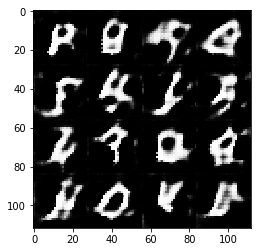

Epoch 3/3... Step 1210... Discriminator Loss: 1.3458... Generator Loss: 0.8576
Epoch 3/3... Step 1220... Discriminator Loss: 0.9211... Generator Loss: 1.3033
Epoch 3/3... Step 1230... Discriminator Loss: 0.9880... Generator Loss: 1.6000
Epoch 3/3... Step 1240... Discriminator Loss: 1.4614... Generator Loss: 0.8923
Epoch 3/3... Step 1250... Discriminator Loss: 0.9931... Generator Loss: 1.1827
Epoch 3/3... Step 1260... Discriminator Loss: 1.0199... Generator Loss: 1.5799
Epoch 3/3... Step 1270... Discriminator Loss: 1.1956... Generator Loss: 1.2546
Epoch 3/3... Step 1280... Discriminator Loss: 0.8117... Generator Loss: 1.7400
Epoch 3/3... Step 1290... Discriminator Loss: 1.3329... Generator Loss: 0.9127
Epoch 3/3... Step 1300... Discriminator Loss: 1.2482... Generator Loss: 0.9830
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_13/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


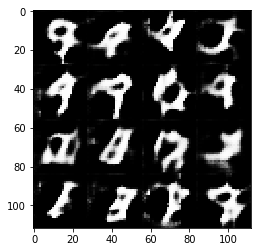

Epoch 3/3... Step 1310... Discriminator Loss: 1.1251... Generator Loss: 0.9564
Epoch 3/3... Step 1320... Discriminator Loss: 0.9552... Generator Loss: 1.7405
Epoch 3/3... Step 1330... Discriminator Loss: 1.3281... Generator Loss: 1.1207
Epoch 3/3... Step 1340... Discriminator Loss: 1.2616... Generator Loss: 1.0344
Epoch 3/3... Step 1350... Discriminator Loss: 0.9604... Generator Loss: 1.5371
Epoch 3/3... Step 1360... Discriminator Loss: 0.8304... Generator Loss: 1.6632
Epoch 3/3... Step 1370... Discriminator Loss: 1.2769... Generator Loss: 1.4047
Epoch 3/3... Step 1380... Discriminator Loss: 1.0686... Generator Loss: 1.2180
Epoch 3/3... Step 1390... Discriminator Loss: 0.8796... Generator Loss: 1.5903
Epoch 3/3... Step 1400... Discriminator Loss: 1.2068... Generator Loss: 1.5388
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_14/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


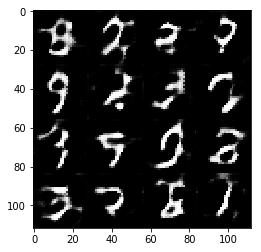

Epoch 3/3... Step 1410... Discriminator Loss: 1.1879... Generator Loss: 1.2677
Epoch 3/3... Step 1420... Discriminator Loss: 0.9934... Generator Loss: 1.5149
Epoch 3/3... Step 1430... Discriminator Loss: 1.0126... Generator Loss: 1.5208
Epoch 3/3... Step 1440... Discriminator Loss: 1.0771... Generator Loss: 1.4147
Epoch 3/3... Step 1450... Discriminator Loss: 1.3051... Generator Loss: 1.3096
Epoch 3/3... Step 1460... Discriminator Loss: 1.1131... Generator Loss: 1.0240
Epoch 3/3... Step 1470... Discriminator Loss: 0.9579... Generator Loss: 1.2561
Epoch 3/3... Step 1480... Discriminator Loss: 1.0458... Generator Loss: 1.3633
Epoch 3/3... Step 1490... Discriminator Loss: 1.1933... Generator Loss: 1.3062
Epoch 3/3... Step 1500... Discriminator Loss: 1.1756... Generator Loss: 1.2339
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_15/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


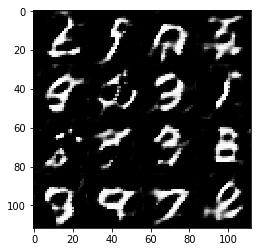

Epoch 3/3... Step 1510... Discriminator Loss: 1.1036... Generator Loss: 1.1483
Epoch 3/3... Step 1520... Discriminator Loss: 0.9981... Generator Loss: 1.3698
Epoch 3/3... Step 1530... Discriminator Loss: 1.1616... Generator Loss: 1.5524
Epoch 3/3... Step 1540... Discriminator Loss: 1.3518... Generator Loss: 1.1740
Epoch 3/3... Step 1550... Discriminator Loss: 1.0695... Generator Loss: 1.2832
Epoch 3/3... Step 1560... Discriminator Loss: 1.0976... Generator Loss: 1.2815
Epoch 3/3... Step 1570... Discriminator Loss: 1.3298... Generator Loss: 1.4727
Epoch 3/3... Step 1580... Discriminator Loss: 1.0800... Generator Loss: 1.3218
Epoch 3/3... Step 1590... Discriminator Loss: 0.8619... Generator Loss: 1.6573
Epoch 3/3... Step 1600... Discriminator Loss: 1.5581... Generator Loss: 0.8837
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_16/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


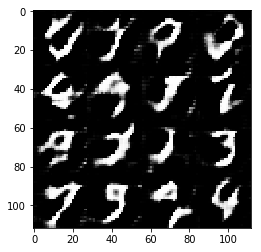

Epoch 3/3... Step 1610... Discriminator Loss: 1.0104... Generator Loss: 1.3590
Epoch 3/3... Step 1620... Discriminator Loss: 1.1611... Generator Loss: 1.6342
Epoch 3/3... Step 1630... Discriminator Loss: 1.0542... Generator Loss: 1.3912
Epoch 3/3... Step 1640... Discriminator Loss: 0.9762... Generator Loss: 1.5138
Epoch 3/3... Step 1650... Discriminator Loss: 1.1722... Generator Loss: 1.1690
Epoch 3/3... Step 1660... Discriminator Loss: 0.8203... Generator Loss: 1.9307
Epoch 3/3... Step 1670... Discriminator Loss: 1.2083... Generator Loss: 1.0352
Epoch 3/3... Step 1680... Discriminator Loss: 0.9334... Generator Loss: 1.5250
Epoch 3/3... Step 1690... Discriminator Loss: 1.0454... Generator Loss: 1.4143
Epoch 3/3... Step 1700... Discriminator Loss: 1.3661... Generator Loss: 1.2491
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_17/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


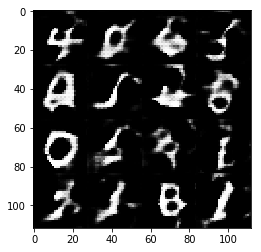

Epoch 3/3... Step 1710... Discriminator Loss: 1.0171... Generator Loss: 1.2090
Epoch 3/3... Step 1720... Discriminator Loss: 0.9493... Generator Loss: 1.7035
Epoch 3/3... Step 1730... Discriminator Loss: 1.1425... Generator Loss: 1.5754
Epoch 3/3... Step 1740... Discriminator Loss: 0.9073... Generator Loss: 1.4461
Epoch 3/3... Step 1750... Discriminator Loss: 1.2962... Generator Loss: 1.4442
Epoch 3/3... Step 1760... Discriminator Loss: 1.0892... Generator Loss: 1.4395
Epoch 3/3... Step 1770... Discriminator Loss: 1.2856... Generator Loss: 1.4549
Epoch 3/3... Step 1780... Discriminator Loss: 1.0055... Generator Loss: 1.3627
Epoch 3/3... Step 1790... Discriminator Loss: 1.6584... Generator Loss: 1.0306
Epoch 3/3... Step 1800... Discriminator Loss: 1.0620... Generator Loss: 1.1531
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_18/Tanh:0", shape=(?, 28, 28, 1), dtype=float32) 1


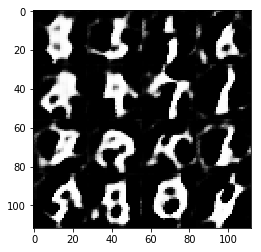

In [ ]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [ ]:
batch_size = 100
z_dim = 100
learning_rate = 0.0015
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3
discriminator-images.shape (?, 28, 28, 3)
model_loss-gmodel: (?, 28, 28, 3)
discriminator-images.shape (?, 28, 28, 3)
Epoch 1/3... Step 10... Discriminator Loss: 1.3450... Generator Loss: 1.5156
Epoch 1/3... Step 20... Discriminator Loss: 1.2687... Generator Loss: 1.1604
Epoch 1/3... Step 30... Discriminator Loss: 0.6148... Generator Loss: 4.9951
Epoch 1/3... Step 40... Discriminator Loss: 0.5951... Generator Loss: 11.4240
Epoch 1/3... Step 50... Discriminator Loss: 0.5340... Generator Loss: 5.8573
Epoch 1/3... Step 60... Discriminator Loss: 0.4154... Generator Loss: 3.7782
Epoch 1/3... Step 70... Discriminator Loss: 0.4033... Generator Loss: 4.3697
Epoch 1/3... Step 80... Discriminator Loss: 0.5094... Generator Loss: 3.5792
Epoch 1/3... Step 90... Discriminator Loss: 0.3937... Generator Loss: 6.2622
Epoch 1/

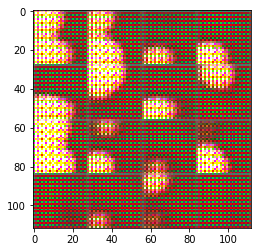

Epoch 1/3... Step 110... Discriminator Loss: 0.3983... Generator Loss: 4.4320
Epoch 1/3... Step 120... Discriminator Loss: 0.4146... Generator Loss: 5.3990
Epoch 1/3... Step 130... Discriminator Loss: 0.3961... Generator Loss: 4.3453
Epoch 1/3... Step 140... Discriminator Loss: 0.5812... Generator Loss: 4.2731
Epoch 1/3... Step 150... Discriminator Loss: 0.3705... Generator Loss: 5.3900
Epoch 1/3... Step 160... Discriminator Loss: 0.5499... Generator Loss: 3.8330
Epoch 1/3... Step 170... Discriminator Loss: 0.4403... Generator Loss: 4.9356
Epoch 1/3... Step 180... Discriminator Loss: 0.5564... Generator Loss: 3.5259
Epoch 1/3... Step 190... Discriminator Loss: 0.4353... Generator Loss: 3.6247
Epoch 1/3... Step 200... Discriminator Loss: 0.4604... Generator Loss: 3.9876
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_2/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


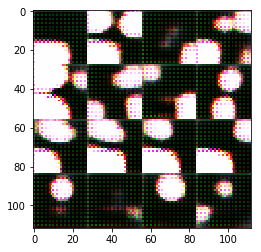

Epoch 1/3... Step 210... Discriminator Loss: 0.8061... Generator Loss: 3.5758
Epoch 1/3... Step 220... Discriminator Loss: 0.4240... Generator Loss: 5.4029
Epoch 1/3... Step 230... Discriminator Loss: 1.2610... Generator Loss: 4.4341
Epoch 1/3... Step 240... Discriminator Loss: 0.3634... Generator Loss: 5.7075
Epoch 1/3... Step 250... Discriminator Loss: 0.5911... Generator Loss: 4.4833
Epoch 1/3... Step 260... Discriminator Loss: 1.1039... Generator Loss: 2.4186
Epoch 1/3... Step 270... Discriminator Loss: 0.5623... Generator Loss: 2.9450
Epoch 1/3... Step 280... Discriminator Loss: 0.6497... Generator Loss: 7.1402
Epoch 1/3... Step 290... Discriminator Loss: 0.4771... Generator Loss: 6.9710
Epoch 1/3... Step 300... Discriminator Loss: 0.4214... Generator Loss: 6.8709
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_3/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


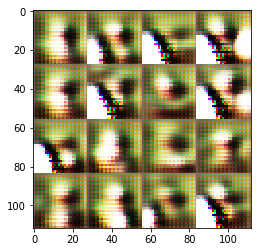

Epoch 1/3... Step 310... Discriminator Loss: 0.8491... Generator Loss: 4.0666
Epoch 1/3... Step 320... Discriminator Loss: 0.5768... Generator Loss: 2.3992
Epoch 1/3... Step 330... Discriminator Loss: 0.6523... Generator Loss: 3.6559
Epoch 1/3... Step 340... Discriminator Loss: 0.4525... Generator Loss: 3.1935
Epoch 1/3... Step 350... Discriminator Loss: 0.6918... Generator Loss: 3.1250
Epoch 1/3... Step 360... Discriminator Loss: 0.5904... Generator Loss: 3.9235
Epoch 1/3... Step 370... Discriminator Loss: 0.7339... Generator Loss: 3.2685
Epoch 1/3... Step 380... Discriminator Loss: 0.8657... Generator Loss: 2.7293
Epoch 1/3... Step 390... Discriminator Loss: 1.4307... Generator Loss: 3.5449
Epoch 1/3... Step 400... Discriminator Loss: 1.1834... Generator Loss: 4.3832
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_4/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


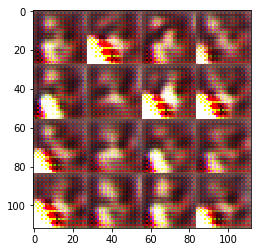

Epoch 1/3... Step 410... Discriminator Loss: 0.5263... Generator Loss: 5.0354
Epoch 1/3... Step 420... Discriminator Loss: 0.7631... Generator Loss: 20.0345
Epoch 1/3... Step 430... Discriminator Loss: 0.5453... Generator Loss: 4.9969
Epoch 1/3... Step 440... Discriminator Loss: 0.9410... Generator Loss: 3.6017
Epoch 1/3... Step 450... Discriminator Loss: 1.3340... Generator Loss: 3.4800
Epoch 1/3... Step 460... Discriminator Loss: 0.6485... Generator Loss: 2.2771
Epoch 1/3... Step 470... Discriminator Loss: 0.6472... Generator Loss: 4.8768
Epoch 1/3... Step 480... Discriminator Loss: 1.1652... Generator Loss: 2.6224
Epoch 1/3... Step 490... Discriminator Loss: 0.7066... Generator Loss: 4.3286
Epoch 1/3... Step 500... Discriminator Loss: 0.5647... Generator Loss: 2.9407
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_5/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


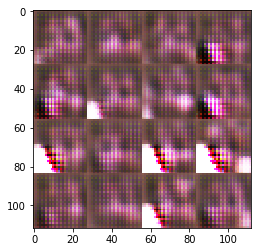

Epoch 1/3... Step 510... Discriminator Loss: 1.1644... Generator Loss: 5.3599
Epoch 1/3... Step 520... Discriminator Loss: 1.4046... Generator Loss: 1.5806
Epoch 1/3... Step 530... Discriminator Loss: 0.9133... Generator Loss: 2.2086
Epoch 1/3... Step 540... Discriminator Loss: 1.5743... Generator Loss: 5.2190
Epoch 1/3... Step 550... Discriminator Loss: 0.5746... Generator Loss: 3.4722
Epoch 1/3... Step 560... Discriminator Loss: 1.1687... Generator Loss: 2.0113
Epoch 1/3... Step 570... Discriminator Loss: 2.1435... Generator Loss: 2.0485
Epoch 1/3... Step 580... Discriminator Loss: 0.6385... Generator Loss: 5.9073
Epoch 1/3... Step 590... Discriminator Loss: 0.8137... Generator Loss: 3.3946
Epoch 1/3... Step 600... Discriminator Loss: 0.8145... Generator Loss: 3.6292
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_6/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


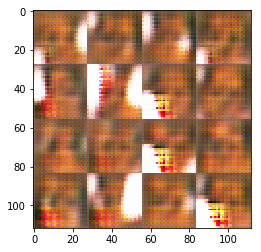

Epoch 1/3... Step 610... Discriminator Loss: 1.8068... Generator Loss: 5.0463
Epoch 1/3... Step 620... Discriminator Loss: 1.3048... Generator Loss: 4.3851
Epoch 1/3... Step 630... Discriminator Loss: 1.0424... Generator Loss: 5.3399
Epoch 1/3... Step 640... Discriminator Loss: 1.9174... Generator Loss: 3.3650
Epoch 1/3... Step 650... Discriminator Loss: 2.4711... Generator Loss: 4.2479
Epoch 1/3... Step 660... Discriminator Loss: 1.6445... Generator Loss: 20.1648
Epoch 1/3... Step 670... Discriminator Loss: 4.6378... Generator Loss: 1.9599
Epoch 1/3... Step 680... Discriminator Loss: 1.6404... Generator Loss: 5.9826
Epoch 1/3... Step 690... Discriminator Loss: 1.2616... Generator Loss: 7.1023
Epoch 1/3... Step 700... Discriminator Loss: 2.9147... Generator Loss: 3.6021
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_7/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


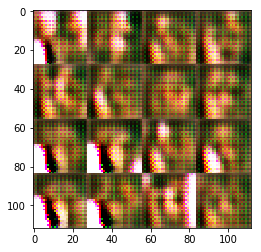

Epoch 1/3... Step 710... Discriminator Loss: 1.4712... Generator Loss: 2.2655
Epoch 1/3... Step 720... Discriminator Loss: 1.6851... Generator Loss: 3.5269
Epoch 1/3... Step 730... Discriminator Loss: 1.0031... Generator Loss: 7.8801
Epoch 1/3... Step 740... Discriminator Loss: 1.3313... Generator Loss: 5.7678
Epoch 1/3... Step 750... Discriminator Loss: 0.6770... Generator Loss: 5.6957
Epoch 1/3... Step 760... Discriminator Loss: 1.5537... Generator Loss: 3.3593
Epoch 1/3... Step 770... Discriminator Loss: 0.6975... Generator Loss: 4.9042
Epoch 1/3... Step 780... Discriminator Loss: 1.7161... Generator Loss: 1.7165
Epoch 1/3... Step 790... Discriminator Loss: 0.6253... Generator Loss: 3.5623
Epoch 1/3... Step 800... Discriminator Loss: 0.9537... Generator Loss: 2.2595
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_8/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


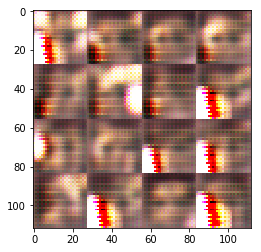

Epoch 1/3... Step 810... Discriminator Loss: 0.6676... Generator Loss: 2.9331
Epoch 1/3... Step 820... Discriminator Loss: 0.7836... Generator Loss: 3.0343
Epoch 1/3... Step 830... Discriminator Loss: 1.0520... Generator Loss: 2.5039
Epoch 1/3... Step 840... Discriminator Loss: 0.8145... Generator Loss: 2.7173
Epoch 1/3... Step 850... Discriminator Loss: 0.5049... Generator Loss: 3.7550
Epoch 1/3... Step 860... Discriminator Loss: 0.8418... Generator Loss: 2.3017
Epoch 1/3... Step 870... Discriminator Loss: 0.7704... Generator Loss: 4.6037
Epoch 1/3... Step 880... Discriminator Loss: 0.5754... Generator Loss: 3.0626
Epoch 1/3... Step 890... Discriminator Loss: 1.1164... Generator Loss: 3.6192
Epoch 1/3... Step 900... Discriminator Loss: 0.9967... Generator Loss: 2.9543
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_9/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


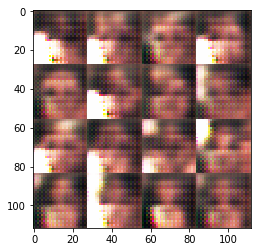

Epoch 1/3... Step 910... Discriminator Loss: 1.0589... Generator Loss: 2.2687
Epoch 1/3... Step 920... Discriminator Loss: 0.7979... Generator Loss: 1.8324
Epoch 1/3... Step 930... Discriminator Loss: 1.0969... Generator Loss: 1.7091
Epoch 1/3... Step 940... Discriminator Loss: 1.0917... Generator Loss: 1.8739
Epoch 1/3... Step 950... Discriminator Loss: 0.9214... Generator Loss: 1.9241
Epoch 1/3... Step 960... Discriminator Loss: 0.8542... Generator Loss: 2.8520
Epoch 1/3... Step 970... Discriminator Loss: 0.7670... Generator Loss: 2.0540
Epoch 1/3... Step 980... Discriminator Loss: 1.2220... Generator Loss: 1.5250
Epoch 1/3... Step 990... Discriminator Loss: 0.8119... Generator Loss: 2.0079
Epoch 1/3... Step 1000... Discriminator Loss: 0.7362... Generator Loss: 2.3649
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_10/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


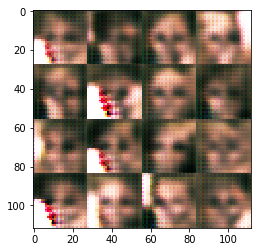

Epoch 1/3... Step 1010... Discriminator Loss: 0.8760... Generator Loss: 2.2951
Epoch 1/3... Step 1020... Discriminator Loss: 0.9792... Generator Loss: 2.2298
Epoch 1/3... Step 1030... Discriminator Loss: 1.6155... Generator Loss: 3.4272
Epoch 1/3... Step 1040... Discriminator Loss: 1.0183... Generator Loss: 1.9290
Epoch 1/3... Step 1050... Discriminator Loss: 0.8388... Generator Loss: 2.4940
Epoch 1/3... Step 1060... Discriminator Loss: 1.0293... Generator Loss: 1.5815
Epoch 1/3... Step 1070... Discriminator Loss: 0.9770... Generator Loss: 2.4253
Epoch 1/3... Step 1080... Discriminator Loss: 1.3739... Generator Loss: 1.6927
Epoch 1/3... Step 1090... Discriminator Loss: 0.9284... Generator Loss: 2.5516
Epoch 1/3... Step 1100... Discriminator Loss: 1.0229... Generator Loss: 2.3526
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_11/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


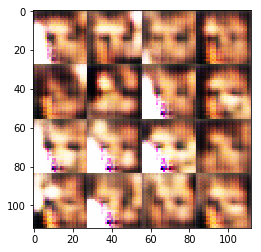

Epoch 1/3... Step 1110... Discriminator Loss: 1.6234... Generator Loss: 2.3689
Epoch 1/3... Step 1120... Discriminator Loss: 1.0691... Generator Loss: 3.4798
Epoch 1/3... Step 1130... Discriminator Loss: 0.9962... Generator Loss: 1.9168
Epoch 1/3... Step 1140... Discriminator Loss: 1.0245... Generator Loss: 1.9061
Epoch 1/3... Step 1150... Discriminator Loss: 0.9568... Generator Loss: 2.1132
Epoch 1/3... Step 1160... Discriminator Loss: 1.2047... Generator Loss: 1.4066
Epoch 1/3... Step 1170... Discriminator Loss: 0.9849... Generator Loss: 2.2368
Epoch 1/3... Step 1180... Discriminator Loss: 1.3594... Generator Loss: 2.3107
Epoch 1/3... Step 1190... Discriminator Loss: 1.3956... Generator Loss: 4.1620
Epoch 1/3... Step 1200... Discriminator Loss: 1.1827... Generator Loss: 1.4295
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_12/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


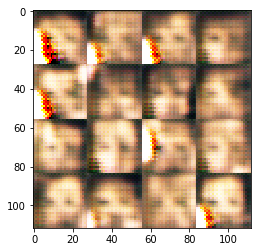

Epoch 1/3... Step 1210... Discriminator Loss: 1.4679... Generator Loss: 2.1671
Epoch 1/3... Step 1220... Discriminator Loss: 1.3058... Generator Loss: 2.7286
Epoch 1/3... Step 1230... Discriminator Loss: 0.9177... Generator Loss: 4.5989
Epoch 1/3... Step 1240... Discriminator Loss: 2.3299... Generator Loss: 3.6762
Epoch 1/3... Step 1250... Discriminator Loss: 1.3813... Generator Loss: 5.3885
Epoch 1/3... Step 1260... Discriminator Loss: 1.0089... Generator Loss: 3.7843
Epoch 1/3... Step 1270... Discriminator Loss: 0.6586... Generator Loss: 3.5274
Epoch 1/3... Step 1280... Discriminator Loss: 1.1809... Generator Loss: 1.8523
Epoch 1/3... Step 1290... Discriminator Loss: 0.6614... Generator Loss: 3.6309
Epoch 1/3... Step 1300... Discriminator Loss: 1.1521... Generator Loss: 2.3153
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_13/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


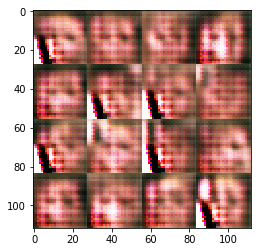

Epoch 1/3... Step 1310... Discriminator Loss: 0.9067... Generator Loss: 4.3305
Epoch 1/3... Step 1320... Discriminator Loss: 1.0775... Generator Loss: 3.6172
Epoch 1/3... Step 1330... Discriminator Loss: 1.2375... Generator Loss: 2.2253
Epoch 1/3... Step 1340... Discriminator Loss: 0.8984... Generator Loss: 2.4485
Epoch 1/3... Step 1350... Discriminator Loss: 1.0693... Generator Loss: 2.7389
Epoch 1/3... Step 1360... Discriminator Loss: 0.7353... Generator Loss: 2.9591
Epoch 1/3... Step 1370... Discriminator Loss: 0.8486... Generator Loss: 3.3385
Epoch 1/3... Step 1380... Discriminator Loss: 1.3721... Generator Loss: 2.2392
Epoch 1/3... Step 1390... Discriminator Loss: 0.7256... Generator Loss: 2.9464
Epoch 1/3... Step 1400... Discriminator Loss: 0.8431... Generator Loss: 2.8213
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_14/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


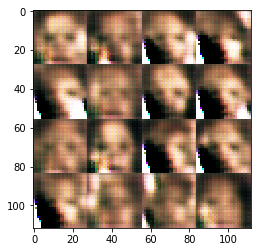

Epoch 1/3... Step 1410... Discriminator Loss: 0.7007... Generator Loss: 3.3850
Epoch 1/3... Step 1420... Discriminator Loss: 1.0328... Generator Loss: 2.4997
Epoch 1/3... Step 1430... Discriminator Loss: 1.0194... Generator Loss: 2.2313
Epoch 1/3... Step 1440... Discriminator Loss: 0.9569... Generator Loss: 2.1532
Epoch 1/3... Step 1450... Discriminator Loss: 1.5133... Generator Loss: 1.5631
Epoch 1/3... Step 1460... Discriminator Loss: 0.8427... Generator Loss: 2.9259
Epoch 1/3... Step 1470... Discriminator Loss: 1.3178... Generator Loss: 2.5510
Epoch 1/3... Step 1480... Discriminator Loss: 0.9172... Generator Loss: 2.8454
Epoch 1/3... Step 1490... Discriminator Loss: 0.7352... Generator Loss: 2.9798
Epoch 1/3... Step 1500... Discriminator Loss: 1.4108... Generator Loss: 2.5982
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_15/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


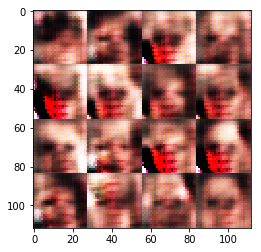

Epoch 1/3... Step 1510... Discriminator Loss: 0.9453... Generator Loss: 3.6933
Epoch 1/3... Step 1520... Discriminator Loss: 1.3930... Generator Loss: 1.5416
Epoch 1/3... Step 1530... Discriminator Loss: 0.8589... Generator Loss: 1.6639
Epoch 1/3... Step 1540... Discriminator Loss: 0.6799... Generator Loss: 2.5391
Epoch 1/3... Step 1550... Discriminator Loss: 0.8755... Generator Loss: 1.9251
Epoch 1/3... Step 1560... Discriminator Loss: 1.1973... Generator Loss: 2.7777
Epoch 1/3... Step 1570... Discriminator Loss: 1.1564... Generator Loss: 2.4254
Epoch 1/3... Step 1580... Discriminator Loss: 0.7514... Generator Loss: 3.5647
Epoch 1/3... Step 1590... Discriminator Loss: 1.3027... Generator Loss: 1.4709
Epoch 1/3... Step 1600... Discriminator Loss: 0.8823... Generator Loss: 1.3947
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_16/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


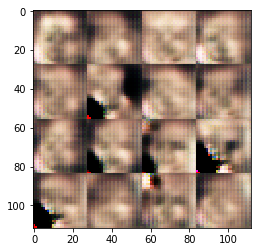

Epoch 1/3... Step 1610... Discriminator Loss: 1.0151... Generator Loss: 2.3697
Epoch 1/3... Step 1620... Discriminator Loss: 1.0648... Generator Loss: 1.4720
Epoch 1/3... Step 1630... Discriminator Loss: 0.7998... Generator Loss: 2.1938
Epoch 1/3... Step 1640... Discriminator Loss: 0.7483... Generator Loss: 1.9586
Epoch 1/3... Step 1650... Discriminator Loss: 1.3354... Generator Loss: 1.6993
Epoch 1/3... Step 1660... Discriminator Loss: 1.0636... Generator Loss: 1.3012
Epoch 1/3... Step 1670... Discriminator Loss: 0.7610... Generator Loss: 2.0654
Epoch 1/3... Step 1680... Discriminator Loss: 1.4295... Generator Loss: 1.0647
Epoch 1/3... Step 1690... Discriminator Loss: 0.7447... Generator Loss: 2.3116
Epoch 1/3... Step 1700... Discriminator Loss: 1.4217... Generator Loss: 1.2629
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_17/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


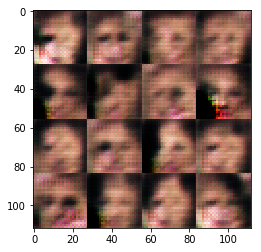

Epoch 1/3... Step 1710... Discriminator Loss: 0.9710... Generator Loss: 1.7317
Epoch 1/3... Step 1720... Discriminator Loss: 1.4157... Generator Loss: 1.4296
Epoch 1/3... Step 1730... Discriminator Loss: 1.1074... Generator Loss: 1.2402
Epoch 1/3... Step 1740... Discriminator Loss: 1.2088... Generator Loss: 2.0449
Epoch 1/3... Step 1750... Discriminator Loss: 1.1226... Generator Loss: 1.0840
Epoch 1/3... Step 1760... Discriminator Loss: 0.7703... Generator Loss: 2.6294
Epoch 1/3... Step 1770... Discriminator Loss: 1.1306... Generator Loss: 1.8850
Epoch 1/3... Step 1780... Discriminator Loss: 0.8866... Generator Loss: 1.6128
Epoch 1/3... Step 1790... Discriminator Loss: 0.9819... Generator Loss: 2.3015
Epoch 1/3... Step 1800... Discriminator Loss: 1.2577... Generator Loss: 1.3511
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_18/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


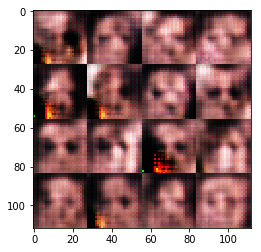

Epoch 1/3... Step 1810... Discriminator Loss: 1.2397... Generator Loss: 2.7530
Epoch 1/3... Step 1820... Discriminator Loss: 1.8500... Generator Loss: 1.7872
Epoch 1/3... Step 1830... Discriminator Loss: 2.4771... Generator Loss: 0.8118
Epoch 1/3... Step 1840... Discriminator Loss: 0.7505... Generator Loss: 1.8132
Epoch 1/3... Step 1850... Discriminator Loss: 0.7909... Generator Loss: 1.8708
Epoch 1/3... Step 1860... Discriminator Loss: 0.9875... Generator Loss: 1.9934
Epoch 1/3... Step 1870... Discriminator Loss: 0.8045... Generator Loss: 3.5393
Epoch 1/3... Step 1880... Discriminator Loss: 1.6794... Generator Loss: 2.0629
Epoch 1/3... Step 1890... Discriminator Loss: 0.9564... Generator Loss: 1.9165
Epoch 1/3... Step 1900... Discriminator Loss: 1.1848... Generator Loss: 1.9707
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_19/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


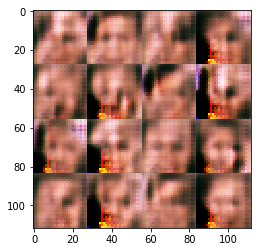

Epoch 1/3... Step 1910... Discriminator Loss: 2.0157... Generator Loss: 1.4160
Epoch 1/3... Step 1920... Discriminator Loss: 1.3697... Generator Loss: 1.3419
Epoch 1/3... Step 1930... Discriminator Loss: 1.0439... Generator Loss: 1.8031
Epoch 1/3... Step 1940... Discriminator Loss: 1.3383... Generator Loss: 1.9124
Epoch 1/3... Step 1950... Discriminator Loss: 0.8710... Generator Loss: 2.7218
Epoch 1/3... Step 1960... Discriminator Loss: 1.3620... Generator Loss: 2.2438
Epoch 1/3... Step 1970... Discriminator Loss: 1.2605... Generator Loss: 1.7314
Epoch 1/3... Step 1980... Discriminator Loss: 1.6884... Generator Loss: 1.6353
Epoch 1/3... Step 1990... Discriminator Loss: 2.7014... Generator Loss: 0.9643
Epoch 1/3... Step 2000... Discriminator Loss: 0.7677... Generator Loss: 1.7223
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_20/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


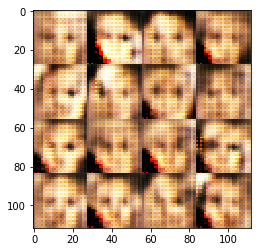

Epoch 1/3... Step 2010... Discriminator Loss: 1.5582... Generator Loss: 0.9497
Epoch 1/3... Step 2020... Discriminator Loss: 1.3719... Generator Loss: 1.4542
Epoch 2/3... Step 2030... Discriminator Loss: 1.8892... Generator Loss: 1.0917
Epoch 2/3... Step 2040... Discriminator Loss: 2.5495... Generator Loss: 2.0667
Epoch 2/3... Step 2050... Discriminator Loss: 2.4306... Generator Loss: 2.8364
Epoch 2/3... Step 2060... Discriminator Loss: 1.0950... Generator Loss: 2.5375
Epoch 2/3... Step 2070... Discriminator Loss: 0.8025... Generator Loss: 3.7302
Epoch 2/3... Step 2080... Discriminator Loss: 1.2250... Generator Loss: 2.9172
Epoch 2/3... Step 2090... Discriminator Loss: 0.9513... Generator Loss: 4.7055
Epoch 2/3... Step 2100... Discriminator Loss: 1.4610... Generator Loss: 2.8472
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_21/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


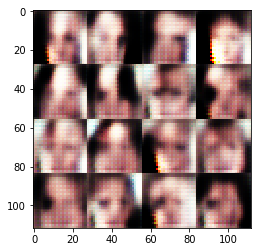

Epoch 2/3... Step 2110... Discriminator Loss: 1.7660... Generator Loss: 2.5046
Epoch 2/3... Step 2120... Discriminator Loss: 0.7948... Generator Loss: 2.8663
Epoch 2/3... Step 2130... Discriminator Loss: 1.5956... Generator Loss: 1.0430
Epoch 2/3... Step 2140... Discriminator Loss: 0.9187... Generator Loss: 2.6369
Epoch 2/3... Step 2150... Discriminator Loss: 0.8064... Generator Loss: 2.3785
Epoch 2/3... Step 2160... Discriminator Loss: 1.4861... Generator Loss: 2.2030
Epoch 2/3... Step 2170... Discriminator Loss: 0.8078... Generator Loss: 2.3137
Epoch 2/3... Step 2180... Discriminator Loss: 0.8127... Generator Loss: 2.1800
Epoch 2/3... Step 2190... Discriminator Loss: 1.5265... Generator Loss: 1.1770
Epoch 2/3... Step 2200... Discriminator Loss: 0.9379... Generator Loss: 1.7498
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_22/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


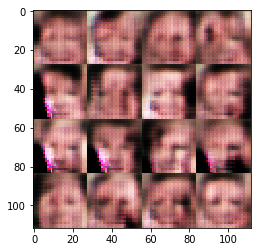

Epoch 2/3... Step 2210... Discriminator Loss: 1.4136... Generator Loss: 1.2477
Epoch 2/3... Step 2220... Discriminator Loss: 1.2277... Generator Loss: 1.3926
Epoch 2/3... Step 2230... Discriminator Loss: 0.8322... Generator Loss: 1.8324
Epoch 2/3... Step 2240... Discriminator Loss: 1.0844... Generator Loss: 1.2433
Epoch 2/3... Step 2250... Discriminator Loss: 0.9604... Generator Loss: 1.7369
Epoch 2/3... Step 2260... Discriminator Loss: 1.2091... Generator Loss: 5.4911
Epoch 2/3... Step 2270... Discriminator Loss: 1.0271... Generator Loss: 2.1893
Epoch 2/3... Step 2280... Discriminator Loss: 1.0969... Generator Loss: 2.5038
Epoch 2/3... Step 2290... Discriminator Loss: 1.4784... Generator Loss: 1.6820
Epoch 2/3... Step 2300... Discriminator Loss: 1.5631... Generator Loss: 0.8774
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_23/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


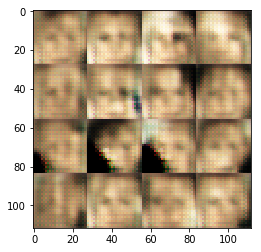

Epoch 2/3... Step 2310... Discriminator Loss: 0.8586... Generator Loss: 1.9736
Epoch 2/3... Step 2320... Discriminator Loss: 1.1280... Generator Loss: 1.9264
Epoch 2/3... Step 2330... Discriminator Loss: 1.1676... Generator Loss: 1.4482
Epoch 2/3... Step 2340... Discriminator Loss: 1.3579... Generator Loss: 0.9680
Epoch 2/3... Step 2350... Discriminator Loss: 1.0243... Generator Loss: 1.7704
Epoch 2/3... Step 2360... Discriminator Loss: 1.4874... Generator Loss: 1.2577
Epoch 2/3... Step 2370... Discriminator Loss: 1.1441... Generator Loss: 1.5074
Epoch 2/3... Step 2380... Discriminator Loss: 0.7116... Generator Loss: 1.7447
Epoch 2/3... Step 2390... Discriminator Loss: 1.2352... Generator Loss: 1.1551
Epoch 2/3... Step 2400... Discriminator Loss: 1.2162... Generator Loss: 1.3563
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_24/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


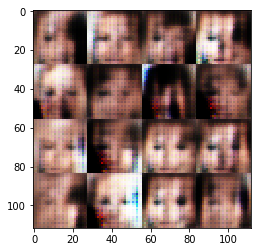

Epoch 2/3... Step 2410... Discriminator Loss: 0.9125... Generator Loss: 1.4363
Epoch 2/3... Step 2420... Discriminator Loss: 1.5967... Generator Loss: 1.4037
Epoch 2/3... Step 2430... Discriminator Loss: 1.2195... Generator Loss: 1.4945
Epoch 2/3... Step 2440... Discriminator Loss: 1.1828... Generator Loss: 1.5049
Epoch 2/3... Step 2450... Discriminator Loss: 0.7730... Generator Loss: 2.3282
Epoch 2/3... Step 2460... Discriminator Loss: 2.0493... Generator Loss: 1.1660
Epoch 2/3... Step 2470... Discriminator Loss: 1.2769... Generator Loss: 2.4189
Epoch 2/3... Step 2480... Discriminator Loss: 0.8581... Generator Loss: 1.7627
Epoch 2/3... Step 2490... Discriminator Loss: 1.0557... Generator Loss: 1.7735
Epoch 2/3... Step 2500... Discriminator Loss: 1.1820... Generator Loss: 1.3020
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_25/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


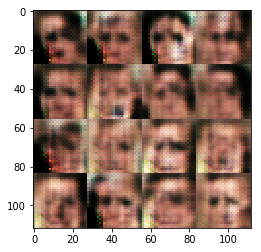

Epoch 2/3... Step 2510... Discriminator Loss: 1.3993... Generator Loss: 1.4272
Epoch 2/3... Step 2520... Discriminator Loss: 1.2455... Generator Loss: 1.3189
Epoch 2/3... Step 2530... Discriminator Loss: 0.8203... Generator Loss: 1.9805
Epoch 2/3... Step 2540... Discriminator Loss: 0.5811... Generator Loss: 3.6092
Epoch 2/3... Step 2550... Discriminator Loss: 1.4901... Generator Loss: 1.4885
Epoch 2/3... Step 2560... Discriminator Loss: 1.4208... Generator Loss: 1.5295
Epoch 2/3... Step 2570... Discriminator Loss: 1.3079... Generator Loss: 1.6114
Epoch 2/3... Step 2580... Discriminator Loss: 0.8173... Generator Loss: 3.6772
Epoch 2/3... Step 2590... Discriminator Loss: 4.9142... Generator Loss: 1.0764
Epoch 2/3... Step 2600... Discriminator Loss: 7.5261... Generator Loss: 2.5865
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_26/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


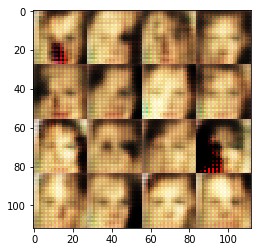

Epoch 2/3... Step 2610... Discriminator Loss: 1.3656... Generator Loss: 3.5271
Epoch 2/3... Step 2620... Discriminator Loss: 0.8175... Generator Loss: 6.0304
Epoch 2/3... Step 2630... Discriminator Loss: 2.3550... Generator Loss: 1.0230
Epoch 2/3... Step 2640... Discriminator Loss: 0.9432... Generator Loss: 1.4687
Epoch 2/3... Step 2650... Discriminator Loss: 0.6863... Generator Loss: 2.1055
Epoch 2/3... Step 2660... Discriminator Loss: 1.1110... Generator Loss: 3.4046
Epoch 2/3... Step 2670... Discriminator Loss: 1.1984... Generator Loss: 2.5941
Epoch 2/3... Step 2680... Discriminator Loss: 1.7686... Generator Loss: 0.8937
Epoch 2/3... Step 2690... Discriminator Loss: 1.0608... Generator Loss: 1.7213
Epoch 2/3... Step 2700... Discriminator Loss: 1.3085... Generator Loss: 1.2420
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_27/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


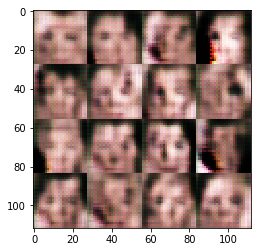

Epoch 2/3... Step 2710... Discriminator Loss: 2.6034... Generator Loss: 1.0190
Epoch 2/3... Step 2720... Discriminator Loss: 1.4150... Generator Loss: 4.3132
Epoch 2/3... Step 2730... Discriminator Loss: 0.8109... Generator Loss: 4.0588
Epoch 2/3... Step 2740... Discriminator Loss: 1.3550... Generator Loss: 1.6064
Epoch 2/3... Step 2750... Discriminator Loss: 0.9838... Generator Loss: 1.5540
Epoch 2/3... Step 2760... Discriminator Loss: 0.8235... Generator Loss: 1.4977
Epoch 2/3... Step 2770... Discriminator Loss: 0.9780... Generator Loss: 1.6294
Epoch 2/3... Step 2780... Discriminator Loss: 0.9822... Generator Loss: 1.5723
Epoch 2/3... Step 2790... Discriminator Loss: 1.5453... Generator Loss: 0.8652
Epoch 2/3... Step 2800... Discriminator Loss: 1.1071... Generator Loss: 1.3011
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_28/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


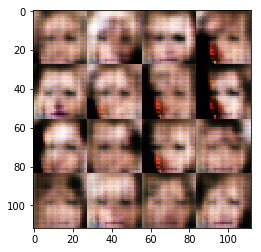

Epoch 2/3... Step 2810... Discriminator Loss: 1.3851... Generator Loss: 1.9522
Epoch 2/3... Step 2820... Discriminator Loss: 1.3522... Generator Loss: 2.2914
Epoch 2/3... Step 2830... Discriminator Loss: 1.5583... Generator Loss: 2.4997
Epoch 2/3... Step 2840... Discriminator Loss: 1.8454... Generator Loss: 1.0475
Epoch 2/3... Step 2850... Discriminator Loss: 1.0676... Generator Loss: 1.1314
Epoch 2/3... Step 2860... Discriminator Loss: 1.5523... Generator Loss: 0.8466
Epoch 2/3... Step 2870... Discriminator Loss: 1.1129... Generator Loss: 1.9930
Epoch 2/3... Step 2880... Discriminator Loss: 0.8791... Generator Loss: 1.7823
Epoch 2/3... Step 2890... Discriminator Loss: 1.3243... Generator Loss: 1.7115
Epoch 2/3... Step 2900... Discriminator Loss: 1.0565... Generator Loss: 1.3812
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_29/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


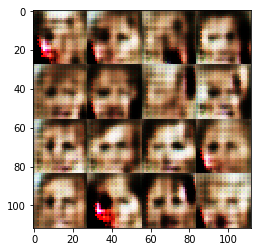

Epoch 2/3... Step 2910... Discriminator Loss: 1.2347... Generator Loss: 1.4292
Epoch 2/3... Step 2920... Discriminator Loss: 1.7096... Generator Loss: 1.2277
Epoch 2/3... Step 2930... Discriminator Loss: 0.5744... Generator Loss: 2.2708
Epoch 2/3... Step 2940... Discriminator Loss: 1.1527... Generator Loss: 1.5700
Epoch 2/3... Step 2950... Discriminator Loss: 1.3991... Generator Loss: 1.2719
Epoch 2/3... Step 2960... Discriminator Loss: 1.1056... Generator Loss: 1.3749
Epoch 2/3... Step 2970... Discriminator Loss: 1.0948... Generator Loss: 1.7765
Epoch 2/3... Step 2980... Discriminator Loss: 1.0889... Generator Loss: 1.1683
Epoch 2/3... Step 2990... Discriminator Loss: 0.8769... Generator Loss: 2.6468
Epoch 2/3... Step 3000... Discriminator Loss: 1.3521... Generator Loss: 1.4035
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_30/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


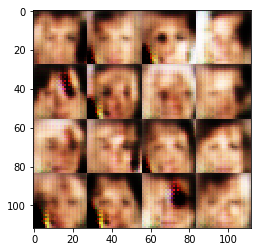

Epoch 2/3... Step 3010... Discriminator Loss: 0.9698... Generator Loss: 1.4100
Epoch 2/3... Step 3020... Discriminator Loss: 1.0139... Generator Loss: 2.0439
Epoch 2/3... Step 3030... Discriminator Loss: 0.8499... Generator Loss: 1.8187
Epoch 2/3... Step 3040... Discriminator Loss: 1.4437... Generator Loss: 1.2737
Epoch 2/3... Step 3050... Discriminator Loss: 0.9235... Generator Loss: 2.1170
Epoch 2/3... Step 3060... Discriminator Loss: 0.8478... Generator Loss: 2.2637
Epoch 2/3... Step 3070... Discriminator Loss: 1.6248... Generator Loss: 1.0900
Epoch 2/3... Step 3080... Discriminator Loss: 0.8203... Generator Loss: 1.7998
Epoch 2/3... Step 3090... Discriminator Loss: 0.9295... Generator Loss: 1.9182
Epoch 2/3... Step 3100... Discriminator Loss: 1.1847... Generator Loss: 1.4987
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_31/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


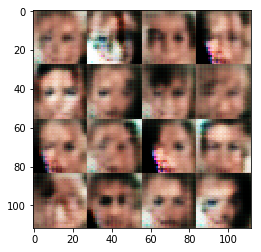

Epoch 2/3... Step 3110... Discriminator Loss: 1.1428... Generator Loss: 1.1668
Epoch 2/3... Step 3120... Discriminator Loss: 0.7909... Generator Loss: 1.6327
Epoch 2/3... Step 3130... Discriminator Loss: 0.9554... Generator Loss: 1.4972
Epoch 2/3... Step 3140... Discriminator Loss: 1.2056... Generator Loss: 1.2936
Epoch 2/3... Step 3150... Discriminator Loss: 1.1335... Generator Loss: 1.3399
Epoch 2/3... Step 3160... Discriminator Loss: 1.0449... Generator Loss: 1.4365
Epoch 2/3... Step 3170... Discriminator Loss: 1.0754... Generator Loss: 1.5731
Epoch 2/3... Step 3180... Discriminator Loss: 0.9413... Generator Loss: 2.3934
Epoch 2/3... Step 3190... Discriminator Loss: 1.0261... Generator Loss: 1.6031
Epoch 2/3... Step 3200... Discriminator Loss: 1.3718... Generator Loss: 1.1427
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_32/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


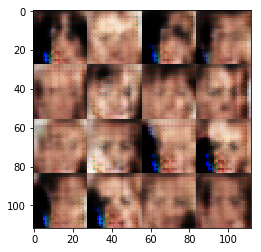

Epoch 2/3... Step 3210... Discriminator Loss: 1.0912... Generator Loss: 1.3287
Epoch 2/3... Step 3220... Discriminator Loss: 1.2237... Generator Loss: 1.4194
Epoch 2/3... Step 3230... Discriminator Loss: 1.4595... Generator Loss: 1.3038
Epoch 2/3... Step 3240... Discriminator Loss: 1.6743... Generator Loss: 1.3548
Epoch 2/3... Step 3250... Discriminator Loss: 0.8326... Generator Loss: 1.8752
Epoch 2/3... Step 3260... Discriminator Loss: 1.0324... Generator Loss: 1.2909
Epoch 2/3... Step 3270... Discriminator Loss: 0.9632... Generator Loss: 1.6357
Epoch 2/3... Step 3280... Discriminator Loss: 1.4888... Generator Loss: 1.3981
Epoch 2/3... Step 3290... Discriminator Loss: 1.2422... Generator Loss: 1.4594
Epoch 2/3... Step 3300... Discriminator Loss: 1.4357... Generator Loss: 1.7747
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_33/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


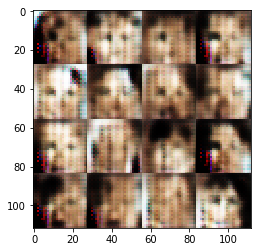

Epoch 2/3... Step 3310... Discriminator Loss: 1.4464... Generator Loss: 1.6424
Epoch 2/3... Step 3320... Discriminator Loss: 1.2948... Generator Loss: 1.2669
Epoch 2/3... Step 3330... Discriminator Loss: 1.3166... Generator Loss: 1.8698
Epoch 2/3... Step 3340... Discriminator Loss: 2.0320... Generator Loss: 1.1512
Epoch 2/3... Step 3350... Discriminator Loss: 0.6555... Generator Loss: 2.8999
Epoch 2/3... Step 3360... Discriminator Loss: 2.0023... Generator Loss: 0.8496
Epoch 2/3... Step 3370... Discriminator Loss: 2.2891... Generator Loss: 1.0881
Epoch 2/3... Step 3380... Discriminator Loss: 1.9148... Generator Loss: 1.9883
Epoch 2/3... Step 3390... Discriminator Loss: 1.6025... Generator Loss: 3.8248
Epoch 2/3... Step 3400... Discriminator Loss: 1.7983... Generator Loss: 2.2008
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_34/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


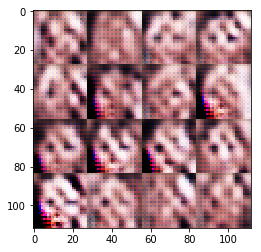

Epoch 2/3... Step 3410... Discriminator Loss: 0.8032... Generator Loss: 2.5065
Epoch 2/3... Step 3420... Discriminator Loss: 0.9946... Generator Loss: 1.2880
Epoch 2/3... Step 3430... Discriminator Loss: 1.4897... Generator Loss: 0.8692
Epoch 2/3... Step 3440... Discriminator Loss: 0.7279... Generator Loss: 2.9293
Epoch 2/3... Step 3450... Discriminator Loss: 1.6419... Generator Loss: 3.0604
Epoch 2/3... Step 3460... Discriminator Loss: 1.1896... Generator Loss: 1.3622
Epoch 2/3... Step 3470... Discriminator Loss: 0.6848... Generator Loss: 3.1450
Epoch 2/3... Step 3480... Discriminator Loss: 2.0424... Generator Loss: 0.7441
Epoch 2/3... Step 3490... Discriminator Loss: 0.7478... Generator Loss: 2.5211
Epoch 2/3... Step 3500... Discriminator Loss: 1.4114... Generator Loss: 1.0523
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_35/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


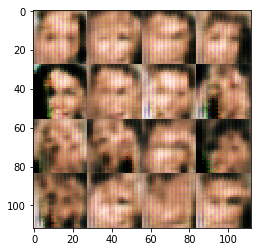

Epoch 2/3... Step 3510... Discriminator Loss: 1.5268... Generator Loss: 1.3347
Epoch 2/3... Step 3520... Discriminator Loss: 1.3500... Generator Loss: 1.3240
Epoch 2/3... Step 3530... Discriminator Loss: 0.9281... Generator Loss: 1.6993
Epoch 2/3... Step 3540... Discriminator Loss: 1.5480... Generator Loss: 1.0040
Epoch 2/3... Step 3550... Discriminator Loss: 0.8675... Generator Loss: 1.7407
Epoch 2/3... Step 3560... Discriminator Loss: 0.8614... Generator Loss: 1.8428
Epoch 2/3... Step 3570... Discriminator Loss: 1.1825... Generator Loss: 1.4562
Epoch 2/3... Step 3580... Discriminator Loss: 1.2675... Generator Loss: 2.0580
Epoch 2/3... Step 3590... Discriminator Loss: 1.3738... Generator Loss: 1.3274
Epoch 2/3... Step 3600... Discriminator Loss: 1.1424... Generator Loss: 1.6027
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_36/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


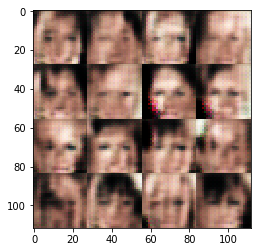

Epoch 2/3... Step 3610... Discriminator Loss: 1.3290... Generator Loss: 0.9641
Epoch 2/3... Step 3620... Discriminator Loss: 0.9221... Generator Loss: 1.4581
Epoch 2/3... Step 3630... Discriminator Loss: 1.3769... Generator Loss: 1.2494
Epoch 2/3... Step 3640... Discriminator Loss: 1.0367... Generator Loss: 1.5443
Epoch 2/3... Step 3650... Discriminator Loss: 1.1494... Generator Loss: 1.6291
Epoch 2/3... Step 3660... Discriminator Loss: 1.3805... Generator Loss: 1.2094
Epoch 2/3... Step 3670... Discriminator Loss: 1.2776... Generator Loss: 1.3567
Epoch 2/3... Step 3680... Discriminator Loss: 0.8718... Generator Loss: 1.4003
Epoch 2/3... Step 3690... Discriminator Loss: 1.1321... Generator Loss: 1.5086
Epoch 2/3... Step 3700... Discriminator Loss: 1.5943... Generator Loss: 1.1937
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_37/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


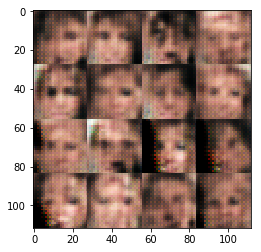

Epoch 2/3... Step 3710... Discriminator Loss: 0.7888... Generator Loss: 1.7334
Epoch 2/3... Step 3720... Discriminator Loss: 1.1231... Generator Loss: 1.3410
Epoch 2/3... Step 3730... Discriminator Loss: 1.9511... Generator Loss: 1.2675
Epoch 2/3... Step 3740... Discriminator Loss: 0.7930... Generator Loss: 1.5503
Epoch 2/3... Step 3750... Discriminator Loss: 1.3855... Generator Loss: 1.6289
Epoch 2/3... Step 3760... Discriminator Loss: 1.4642... Generator Loss: 1.0665
Epoch 2/3... Step 3770... Discriminator Loss: 1.3027... Generator Loss: 1.5028
Epoch 2/3... Step 3780... Discriminator Loss: 0.8613... Generator Loss: 1.5765
Epoch 2/3... Step 3790... Discriminator Loss: 0.8701... Generator Loss: 1.5998
Epoch 2/3... Step 3800... Discriminator Loss: 0.8645... Generator Loss: 1.6109
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_38/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


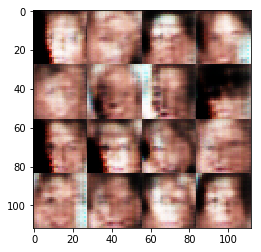

Epoch 2/3... Step 3810... Discriminator Loss: 1.0461... Generator Loss: 1.6230
Epoch 2/3... Step 3820... Discriminator Loss: 1.2764... Generator Loss: 1.3602
Epoch 2/3... Step 3830... Discriminator Loss: 1.1634... Generator Loss: 1.5649
Epoch 2/3... Step 3840... Discriminator Loss: 0.9650... Generator Loss: 1.4966
Epoch 2/3... Step 3850... Discriminator Loss: 0.9468... Generator Loss: 1.8875
Epoch 2/3... Step 3860... Discriminator Loss: 1.3184... Generator Loss: 1.2492
Epoch 2/3... Step 3870... Discriminator Loss: 1.1811... Generator Loss: 1.3055
Epoch 2/3... Step 3880... Discriminator Loss: 1.0720... Generator Loss: 1.4981
Epoch 2/3... Step 3890... Discriminator Loss: 1.1252... Generator Loss: 1.5311
Epoch 2/3... Step 3900... Discriminator Loss: 1.1196... Generator Loss: 1.4673
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_39/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


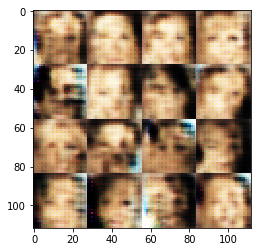

Epoch 2/3... Step 3910... Discriminator Loss: 1.3373... Generator Loss: 1.3864
Epoch 2/3... Step 3920... Discriminator Loss: 1.2288... Generator Loss: 2.0408
Epoch 2/3... Step 3930... Discriminator Loss: 1.2873... Generator Loss: 4.8123
Epoch 2/3... Step 3940... Discriminator Loss: 4.7997... Generator Loss: 1.6760
Epoch 2/3... Step 3950... Discriminator Loss: 0.9511... Generator Loss: 2.1036
Epoch 2/3... Step 3960... Discriminator Loss: 2.2378... Generator Loss: 1.1228
Epoch 2/3... Step 3970... Discriminator Loss: 4.5140... Generator Loss: 2.8800
Epoch 2/3... Step 3980... Discriminator Loss: 1.2732... Generator Loss: 1.7290
Epoch 2/3... Step 3990... Discriminator Loss: 1.8154... Generator Loss: 1.8276
Epoch 2/3... Step 4000... Discriminator Loss: 1.0354... Generator Loss: 1.4389
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_40/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


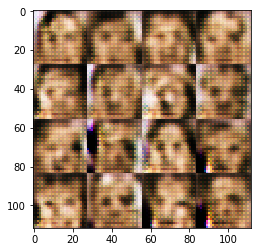

Epoch 2/3... Step 4010... Discriminator Loss: 1.1358... Generator Loss: 2.1323
Epoch 2/3... Step 4020... Discriminator Loss: 1.1466... Generator Loss: 1.7157
Epoch 2/3... Step 4030... Discriminator Loss: 1.4413... Generator Loss: 1.0831
Epoch 2/3... Step 4040... Discriminator Loss: 0.9046... Generator Loss: 1.9147
Epoch 2/3... Step 4050... Discriminator Loss: 1.0108... Generator Loss: 1.9964
Epoch 3/3... Step 4060... Discriminator Loss: 1.9968... Generator Loss: 1.3263
Epoch 3/3... Step 4070... Discriminator Loss: 0.8119... Generator Loss: 1.6682
Epoch 3/3... Step 4080... Discriminator Loss: 1.0211... Generator Loss: 1.3943
Epoch 3/3... Step 4090... Discriminator Loss: 1.7334... Generator Loss: 0.8752
Epoch 3/3... Step 4100... Discriminator Loss: 0.6747... Generator Loss: 1.8267
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_41/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


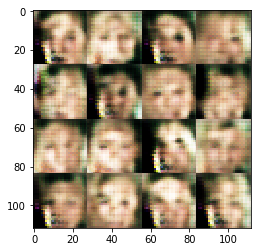

Epoch 3/3... Step 4110... Discriminator Loss: 1.3128... Generator Loss: 1.1806
Epoch 3/3... Step 4120... Discriminator Loss: 1.3263... Generator Loss: 0.9503
Epoch 3/3... Step 4130... Discriminator Loss: 0.8772... Generator Loss: 1.9500
Epoch 3/3... Step 4140... Discriminator Loss: 0.9897... Generator Loss: 1.5374
Epoch 3/3... Step 4150... Discriminator Loss: 1.3606... Generator Loss: 1.3180
Epoch 3/3... Step 4160... Discriminator Loss: 1.0163... Generator Loss: 1.3622
Epoch 3/3... Step 4170... Discriminator Loss: 1.0411... Generator Loss: 1.4491
Epoch 3/3... Step 4180... Discriminator Loss: 1.0343... Generator Loss: 1.7813
Epoch 3/3... Step 4190... Discriminator Loss: 1.5541... Generator Loss: 1.0233
Epoch 3/3... Step 4200... Discriminator Loss: 1.3389... Generator Loss: 0.9858
generator z Tensor("input_z:0", shape=(?, 100), dtype=float32)
generator x1.shape (?, 25088)
out, out_channel_dim Tensor("generator_42/Tanh:0", shape=(?, 28, 28, 3), dtype=float32) 3


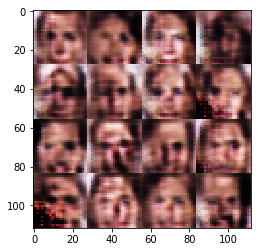

In [ ]:
batch_size = 100
z_dim = 100
learning_rate = 0.001
beta1 = 0.9


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.